# Monitoring Water Quality

* **Products used:** 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[wofs_ls](https://explorer.digitalearth.africa/products/wofs_ls)

## Background
The UN [SDG 6.3.2](https://www.sdg6monitoring.org/indicator-632/) indicator is the "proportion of bodies of water with good ambient water quality". There are many ways to measure water quality using remote sensing based algorithms; this notebook compares several of them. They usually estimate the amount of suspended matter in water.

## Description
This notebook shows results for three empirical algorithms and one spectral index addressing total suspended matter (TSM) in water.
There are a number of caveats to be aware of when applying these algorithms:

* These algorithms were developed for specific regions of the world and are not necessarily universally valid.
* Landsat-8 data is a surface reflectance product, and since water has a very low radiance, the accuracy of the results can be severaly impacted by small differences in atmospheric conditions, or differences in atmospheric correction algorithms.
* The colorbars for these results have been removed to avoid showing specific quantities for the TSM results. It is best to use these results to assess qualitative changes in water quality (e.g. low, medium, high). With improvements in analysis-ready data (e.g. water leaving radiance), and with in-situ sampling of water bodies for empirical modelling, it will be possible to increase the accuracy of these water quality results and even consider the numerical output. 


The showcased water quality algorithms are:

1. Lymburner Total Suspended Matter (TSM)
2. Suspended Particulate Model (SPM)
3. Normalized Difference Suspended Sediment Index (NDSSI)
4. Quang Total Suspended Solids (TSS)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.geom import Geometry

from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs, wofs_fuser
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Monitoring_water_quality")

### Analysis parameters

The following cell sets important parameters for the analysis. The parameters are:

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `lat_buffer`: The number of degrees to load around the central latitude.
* `lon_buffer`: The number of degrees to load around the central longitude.
* `time_range`: The time range to analyze - in YYYY-MM-DD format (e.g. `('2016-01-01', '2016-12-31')`).

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers water quality in Lake Manyara.

**To run the notebook for a different area**, make sure Landsat 8 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check Landsat 8 (`ls8_sr`).

#### Suggested areas
Here are some suggestions for areas to look at. To view one of these areas, copy and paste the parameter values into the cell below, then run the notebook.

**Lake Manyara, Tanzania**
```
lat = -3.611
lon = 35.8261
lat_buffer = 0.2025
lon_buffer = 0.1025
```

**Weija Reservoir, Ghana**
```
lat = 5.583
lon = -0.366
lat_buffer = 0.042
lon_buffer = 0.038
```

**Lake Sulunga, Tanzania**
```
lat = -6.06
lon = 35.17
lat_buffer = 0.2
lon_buffer = 0.19
```

### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=-3.611, lon=35.8261 , lat_buffer = 0.2025, lon_buffer = 0.1025)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Time period
time_range = ("2016-02-16")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

## Load the data
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (i.e. Landsat 7 and Landsat 8), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels.

In the example below, we request that the function returns only observations which are 90% free of clouds and other poor quality pixels by specifying `min_gooddata=0.90`.

In [5]:
# Create the 'query' dictionary object, which contains the longitudes,
# latitudes and time provided above
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "resolution": (-30, 30),
    "align": (15, 15),
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load available data
ds = load_ard(
    dc=dc,
    products=['ls8_sr'],
    measurements=["red", "green", "blue", "nir"],
    group_by="solar_day",
    dask_chunks={"time": 1, "x": 2000, "y": 2000},
    output_crs=output_crs,
    **query
)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 1 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
print(ds)

<xarray.Dataset> Size: 18MB
Dimensions:      (time: 1, y: 1498, x: 765)
Coordinates:
  * time         (time) datetime64[ns] 8B 2016-02-16T07:49:41.042103
  * y            (y) float64 12kB -3.772e+05 -3.772e+05 ... -4.22e+05 -4.221e+05
  * x            (x) float64 6kB 8.025e+05 8.026e+05 ... 8.254e+05 8.254e+05
    spatial_ref  int32 4B 32636
Data variables:
    red          (time, y, x) float32 5MB dask.array<chunksize=(1, 1498, 765), meta=np.ndarray>
    green        (time, y, x) float32 5MB dask.array<chunksize=(1, 1498, 765), meta=np.ndarray>
    blue         (time, y, x) float32 5MB dask.array<chunksize=(1, 1498, 765), meta=np.ndarray>
    nir          (time, y, x) float32 5MB dask.array<chunksize=(1, 1498, 765), meta=np.ndarray>
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref


### Load WOfS

To make sure the algorithms for measuring water quality are only applied to areas with water, it is useful to extract the water extent from the [Water Observations from Space (WOfS) product](https://explorer.digitalearth.africa/wofs_ls).
The water extent can then be used to mask the geomedian composite so that the water quality indices are only shown for pixels that are water.
Pixels that are water are selected using the condition that `water == 128`. 
To learn more about working with WOfS bit flags, see the [Applying WOfS bitmasking notebook](Applying_WOfS_bitmasking.ipynb).

In [7]:
# Load water observations
water = dc.load(
            product="wofs_ls",
            group_by="solar_day",
            like=ds.geobox,
            dask_chunks={"time": 1, "x": 2000, "y": 2000},
            collection_category='T1',
            time=query['time']).water 

#extract from mask the areas classified as water
water_extent = (water == 128).squeeze()

print(water_extent)

<xarray.DataArray 'water' (y: 1498, x: 765)> Size: 1MB
dask.array<getitem, shape=(1498, 765), dtype=bool, chunksize=(1498, 765), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2016-02-16T07:49:41.042103
  * y            (y) float64 12kB -3.772e+05 -3.772e+05 ... -4.22e+05 -4.221e+05
  * x            (x) float64 6kB 8.025e+05 8.026e+05 ... 8.254e+05 8.254e+05
    spatial_ref  int32 4B 32636


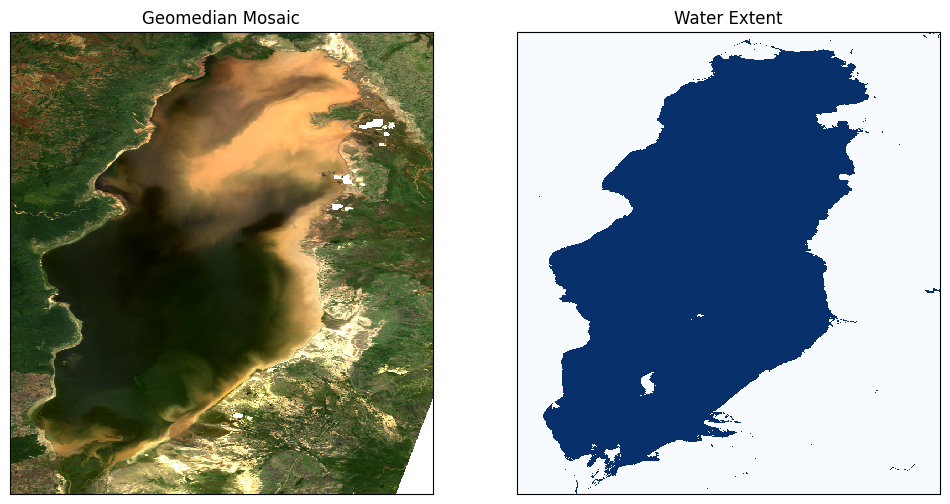

In [8]:
# Plot the geomedian composite and water extent
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#plot the true colour image
rgb(ds, ax=ax[0])

#plot the water extent from WOfS
water_extent.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

# Titles
ax[0].set_title("Geomedian Mosaic"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Water Extent"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);


If the default settings were used, we should see that Lake Manyara appears to be significantly polluted in the northern half on February 16, 2016.

## Total Suspended Sediment Algorithms

First we will calculate the water quality using each of the algorithms, then we wil compare the approaches.

### (1) Lymburner Total Suspended Matter (TSM)
Paper: [Lymburner et al. 2016](https://www.sciencedirect.com/science/article/abs/pii/S0034425716301560)

Units of mg/L concentration

TSM for Landsat 7:
$$
LYM7 = 3983 \cdot (\frac{(\text{Green} + \text{Red}) * 0.0001}{2})^{1.6246}
$$

TSM for Landsat 8:
$$
LYM8 = 3957 \cdot (\frac{(\text{Green} + \text{Red}) * 0.0001}{2})^{1.6436}
$$

Here, we're using Landsat 8, so we'll use the LYM8 function.

In [9]:
# Function to calculate Lymburner TSM value for Landsat 7
def LYM7(dataset):
    return 3983 * ((dataset.green + dataset.red) * 0.0001 / 2) ** 1.6246

In [10]:
# Function to calculate Lymburner TSM value for Landsat 8
def LYM8(dataset):
    return 3957 * ((dataset.green + dataset.red) * 0.0001 / 2) ** 1.6436

In [11]:
# Calculate the Lymburner TSM value for Landsat 8, using water extent to mask
lym8 = LYM8(ds).where(water_extent)

In [12]:
# Determine the 2% and 98% quantiles and set as min and max respectively
lym8_min = lym8.quantile(0.02).values
lym8_max = lym8.quantile(0.98).values

### (2) Suspended Particulate Model (SPM)
Paper: [Zhongfeng Qiu et.al. 2013](https://www.researchgate.net/publication/260152686_A_simple_optical_model_to_estimate_suspended_particulate_matter_in_Yellow_River_Estuary)

Units of g/m^3 concentration

SPM for Landsat 8:
$$
X = 2.26*(\frac{\text{Red}}{\text{Green}})^3 - 
           5.42*(\frac{\text{Red}}{\text{Green}})^2 +
           5.58*(\frac{\text{Red}}{\text{Green}}) - 0.72
$$

$$
SPM = 10^{X} - 1.43
$$

In [13]:
# Function to calculate Suspended Particulate Model value
def SPM_QIU(dataset):
    return (
        10 ** (
            2.26 * (dataset.red / dataset.green) ** 3
            - 5.42 * (dataset.red / dataset.green) ** 2
            + 5.58 * (dataset.red / dataset.green)
            - 0.72
        )
        - 1.43
    )

In [14]:
# Calculate the SPM value for Landsat 8, using water extent to mask
spm_qiu = SPM_QIU(ds).where(water_extent)

In [15]:
# Determine the 2% and 98% quantiles and set as min and max respectively
spm_qiu_min = spm_qiu.quantile(0.02).values
spm_qiu_max = spm_qiu.quantile(0.98).values

### (3) Normalized Difference Suspended Sediment Index (NDSSI)
Paper: [Hossain et al. 2010](https://www.researchgate.net/publication/251236287_Development_of_Remote_Sensing_Based_Index_for_EstimatingMapping_Suspended_Sediment_Concentration_in_River_and_Lake_Environments)

NDSSI for Landsat 7 and 8:
$$
NDSSI = \frac{\text{Blue}-\text{NIR}}{\text{Blue}+\text{NIR}}
$$

The NDSSI value ranges from -1 to +1. Values closer to +1 indicate higher concentration of sediment.

In [16]:
# Function to calculate SNDSSI value
def NDSSI(dataset):
    return (dataset.blue - dataset.nir) / (dataset.blue + dataset.nir)

In [17]:
# Calculate the NDSSI value for Landsat 8, using water extent to mask
ndssi = NDSSI(ds).where(water_extent)

In [18]:
# Determine the 2% and 98% quantiles and set as min and max respectively
ndssi_min = ndssi.quantile(0.02).compute().values
ndssi_max = ndssi.quantile(0.98).compute().values

### (4) Quang Total Suspended Solids (TSS)
Paper: [Quang et al. 2017](https://www.mdpi.com/2073-4441/9/8/570)

Units of mg/L concentration

$$
Quang8 = 380.32 * \text{Red}*0.0001 - 1.7826
$$

In [19]:
# Function to calculate quang8 value
def QUANG8(dataset):
    return 380.32 * (dataset.red) * 0.0001 - 1.7826

In [20]:
# Calculate the quang8 value for Landsat 8, using water extent to mask
quang8 = QUANG8(ds).where(water_extent)

In [21]:
# Determine the 2% and 98% quantiles and set as min and max respectively
quang8_min = quang8.quantile(0.02).compute().values
quang8_max = quang8.quantile(0.98).compute().values

## Compare the algorithms' outputs

Total Suspended Matter (Black=Low, Purple=Medium-Low, Orange=Medium-High, Yellow=High)


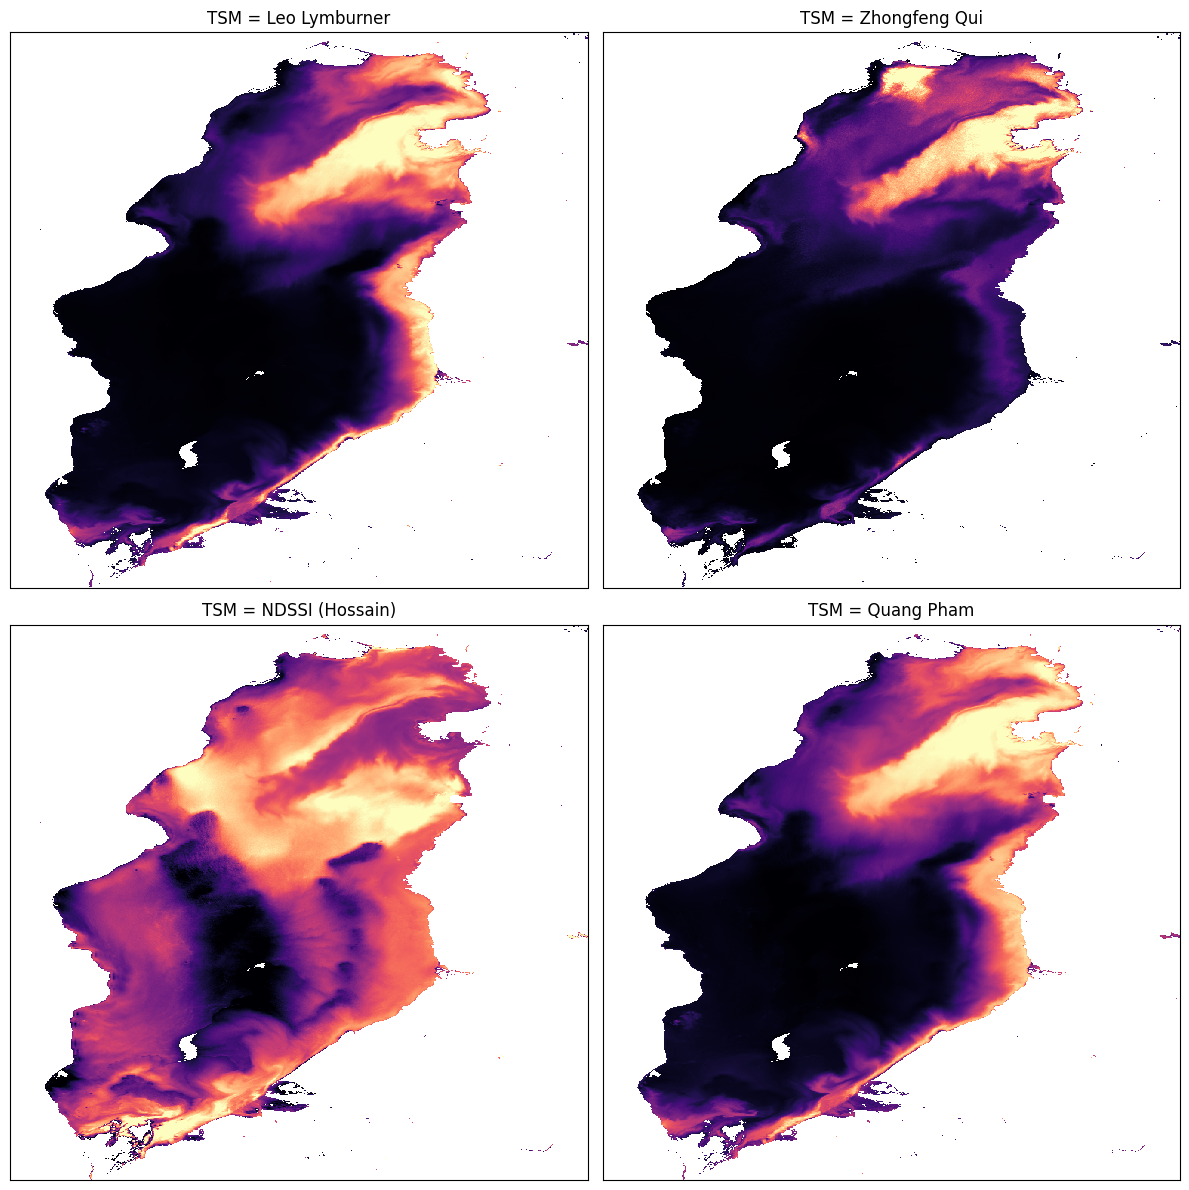

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
cmap='magma'

lym8.plot(
    ax=ax[0, 0], cmap=cmap, add_colorbar=False, vmin=lym8_min, vmax=lym8_max
)

spm_qiu.plot(
    ax=ax[0, 1], cmap=cmap, add_colorbar=False, vmin=spm_qiu_min, vmax=spm_qiu_max
)

ndssi.plot(
    ax=ax[1, 0], cmap=cmap, add_colorbar=False, vmin=ndssi_min, vmax=ndssi_max
)

quang8.plot(
    ax=ax[1, 1], cmap=cmap, add_colorbar=False, vmin=quang8_min, vmax=quang8_max
)

print(
    "Total Suspended Matter (Black=Low, Purple=Medium-Low, "
    "Orange=Medium-High, Yellow=High)"
)

# Titles
ax[0, 0].set_title("TSM = Leo Lymburner"), ax[0, 0].xaxis.set_visible(False), ax[0, 0].yaxis.set_visible(False)
ax[0, 1].set_title("TSM = Zhongfeng Qui"), ax[0, 1].xaxis.set_visible(False), ax[0, 1].yaxis.set_visible(False)
ax[1, 0].set_title("TSM = NDSSI (Hossain)"), ax[1, 0].xaxis.set_visible(False), ax[1, 0].yaxis.set_visible(False)
ax[1, 1].set_title("TSM = Quang Pham"), ax[1, 1].xaxis.set_visible(False), ax[1, 1].yaxis.set_visible(False)

plt.tight_layout();

If the default settings were used, we should see that all the indices reflect the appearance of the lake (where murky, the index is high) except NDSSI, though it does appear to be related to the others - mostly low where the others are high and vice versa.

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [23]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-01-16'